![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
Notebook Authors: Paul Brunzema

# Learning a discrete time dynamics model with PyTorch

In this notebook, we will learn the discrete time dynamics of the cart pole system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## The Cart Pole System

<center><img width="350"  align="left" style="margin-left: 10px; margin-right: 20px;" src="./static/cartpole.png" /></center>

A classic benchmark system in control and reinforcement learning

**States**

- position of the cart $p$
- angle of the pole $\theta$
- velocity of the cart $\dot p$ 
- angular velocity of the pole $\dot\theta$

**Input**

- Force applied to the cart $F$

In [ ]:
# Example parameters
_DEFAULT_PARAMS = {
    "M": 1.0,  # Mass of cart (kg)
    "m": 0.1,  # Mass of pole (kg)
    "J": 0.01,  # Moment of inertia of pole (kg*m^2)
    "l": 0.5,  # Length to COM of pole (m)
    "c": 0.1,  # Cart friction coefficient
    "gamma": 0.01,  # Pole friction coefficient
    "g": 9.81,  # Gravity (m/s^2)
}


class CartPole:
    """
    Cart-pole system simulation model.
    """

    def __init__(self, params=False):
        """
        Initialize the cart-pole system with physical parameters.

        Args:
            params (dict): Parameters of the cart-pole system
        """
        self.params = {
            **_DEFAULT_PARAMS,
            **(params or {}),
        }

    def dynamics(self, t, state, u):
        """
        Compute the dynamics of the cart-pole system.

        Args:
            t (float): Time (not used in this system, but required for compatibility)
            state (numpy.ndarray): State vector [p, theta, dotp, theta_dot]
            u (float): Input force F

        Returns:
            numpy.ndarray: Time derivative of the state vector
        """
        # Extract state variables
        p, theta, p_dot, theta_dot = state

        # Extract parameters
        M = self.params["M"]  # Mass of the base (cart)
        m = self.params["m"]  # Mass of the pole
        J = self.params["J"]  # Moment of inertia of the pole
        l = self.params["l"]  # Distance from base to center of mass
        c = self.params["c"]  # Coefficient of viscous friction for cart
        gamma = self.params["gamma"]  # Coefficient of viscous friction for pole
        g = self.params["g"]  # Gravity acceleration

        # Compute total mass and total inertia
        Mt = M + m
        Jt = J + m * l**2

        # Compute sine and cosine of theta (using shorthand from equations)
        s_theta = np.sin(theta)
        c_theta = np.cos(theta)

        # First two state derivatives (directly from state definition)
        dp = p_dot
        dtheta = theta_dot

        # Third derivative (ddp) - cart acceleration
        numerator_p_ddot = (
            -m * l * s_theta * theta_dot**2
            + m * g * (m * l**2 / Jt) * s_theta * c_theta
            - c * p_dot
            - (gamma / Jt) * m * l * c_theta * theta_dot
            + u
        )
        denominator_p_ddot = Mt - m * (m * l**2 / Jt) * c_theta**2
        dp_dot = numerator_p_ddot / denominator_p_ddot

        # Fourth derivative (ddtheta) - pole angular acceleration
        numerator_theta_ddot = (
            -m * l**2 * s_theta * c_theta * theta_dot**2
            + Mt * g * l * s_theta
            - c * l * c_theta * p_dot
            - gamma * (Mt / m) * theta_dot
            + l * c_theta * u
        )
        denominator_theta_ddot = Jt * (Mt / m) - m * (l * c_theta) ** 2
        dtheta_dot = numerator_theta_ddot / denominator_theta_ddot

        # Combine into the derivative of the state vector
        dx = np.array([dp, dtheta, dp_dot, dtheta_dot])
        return dx

    def get_upper_linearized_dynamics(self):
        """
        Compute the linearized dynamics of the cart-pole system of the upper equilibrium point.

        Returns:
            tuple: A tuple containing:
                numpy.ndarray: A - State matrix
                numpy.ndarray: B - Input matrix
        """
        # Extract parameters
        M = self.params["M"]  # Mass of the base (cart)
        m = self.params["m"]  # Mass of the pole
        J = self.params["J"]  # Moment of inertia of the pole
        l = self.params["l"]  # Distance from base to center of mass
        c = self.params["c"]  # Coefficient of viscous friction for cart
        gamma = self.params["gamma"]  # Coefficient of viscous friction for pole
        g = self.params["g"]  # Gravity acceleration

        # Compute total mass and total inertia
        Mt = M + m
        Jt = J + m * l**2
        mu = Mt * Jt - m**2 * l**2

        # State matrix
        A = np.array(
            [
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [0, m**2 * l**2 * g / mu, -c * Jt / mu, -gamma * l * m / mu],
                [0, Mt * m * g * l / mu, -c * l * m / mu, -gamma * Mt / mu],
            ]
        )

        # Input matrix
        B = np.array([[0], [0], [Jt / mu], [l * m / mu]])
        return A, B

    def rk4_step(self, state, u, dt):
        """
        Single RK4 integration step.
        (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)

        Args:
            state: Current state vector
            u: Control input
            dt: Time step

        Returns:
            Next state after one RK4 step
        """
        k1 = self.dynamics(0, state, u)
        k2 = self.dynamics(0, state + dt / 2 * k1, u)
        k3 = self.dynamics(0, state + dt / 2 * k2, u)
        k4 = self.dynamics(0, state + dt * k3, u)

        next_state = state + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return next_state

    def simulate(
        self,
        initial_state,
        controller=None,
        t_span=(0, 5),
        dt_sim=0.01,
        dt_control=0.02,
    ):
        """
        Simulate the system with a fixed control update frequency that potentially differs from simulation time step.

        Args:
            initial_state (array): Initial state [x, theta, x_dot, theta_dot]
            controller (function): Control law u = f(t, state)
            t_span (tuple): Time span (t_start, t_end)
            dt_sim (float): Simulation time step (for physics)
            dt_control (float): Control update interval (for controller)

        Returns:
            tuple: A tuple containing (time_array, state_array, control_array)
        """
        # Create time array for simulation
        t = np.arange(t_span[0], t_span[1], dt_sim)
        n_steps = len(t)

        # Initialize state and control arrays
        x = np.zeros((4, n_steps))
        u = np.zeros(n_steps)
        x[:, 0] = initial_state

        # Initialize control time and value
        next_control_time = t_span[0]
        current_control = 0.0

        # Function to compute state derivative with current control value
        def state_derivatives(t_current, state_current, control_current):
            return self.dynamics(t_current, state_current, control_current)

        # Simple fixed-step Runge-Kutta 4 integration
        for i in range(n_steps - 1):
            current_time = t[i]

            # Update control only at control frequency
            if current_time >= next_control_time:
                if controller is not None:
                    current_control = controller(current_time, x[:, i])
                else:
                    current_control = 0.0

                next_control_time = current_time + dt_control

            # Store the current control value
            u[i] = current_control

            # RK4 integration step
            x[:, i + 1] = self.rk4_step(x[:, i], u[i], dt_sim)

        # Set the last control value
        if i + 1 < n_steps:
            u[i + 1] = current_control

        return t, x, u

### Set up data generation

To learn the dynamics we need data. For this, we implement the following data generation method.


In [ ]:
def generate_discrete_trajectory_data(
    self,
    n_trajectories=100,
    t_span=(0, 5),
    dt=0.01,
    controller=None,
    state_noise_std=0.0,
    control_noise_std=0.0,
):
    """
    Generate trajectory data for discrete dynamics learning by running multiple simulations
    with random initial conditions. This generates pairs of (x_k, u_k) -> x_{k+1}.

    Args:
        n_trajectories (int): Number of trajectories to generate
        t_span (tuple): Time span for each trajectory
        dt (float): Discrete time step (same as simulation time step)
        controller (function): Controller to use (if None, uses random control)
        state_noise_std (float): Standard deviation of noise added to states
        control_noise_std (float): Standard deviation of noise added to controls
        include_trajectory_segments (bool): If True, include consecutive segments for better learning
        segment_length (int): Length of trajectory segments to include

    Returns:
        tuple: (current_states, controls, next_states) arrays for training
            - current_states: (N, 4) current states x_k
            - controls: (N, 1) applied controls u_k
            - next_states: (N, 4) next states x_{k+1}
    """
    all_current_states = []
    all_controls = []
    all_next_states = []

    for traj_idx in range(n_trajectories):
        # Generate random initial conditions with varied ranges
        if traj_idx % 3 == 0:
            # Some trajectories near equilibrium
            initial_state = np.array(
                [
                    np.random.uniform(-0.5, 0.5),  # position
                    np.random.uniform(-np.pi / 6, np.pi / 6),  # angle
                    np.random.uniform(-0.5, 0.5),  # velocity
                    np.random.uniform(-0.5, 0.5),  # angular velocity
                ]
            )
        elif traj_idx % 3 == 1:
            # Some with larger angles
            initial_state = np.array(
                [
                    np.random.uniform(-1, 1),  # position
                    np.random.uniform(-np.pi / 2, np.pi / 2),  # larger angle range
                    np.random.uniform(-1, 1),  # velocity
                    np.random.uniform(-1, 1),  # angular velocity
                ]
            )
        else:
            # Some with higher velocities
            initial_state = np.array(
                [
                    np.random.uniform(-0.5, 0.5),  # position
                    np.random.uniform(-np.pi / 4, np.pi / 4),  # angle
                    np.random.uniform(-2, 2),  # higher velocity
                    np.random.uniform(-2, 2),  # higher angular velocity
                ]
            )

        # Use provided controller or random controller
        if controller is None:
            # Random controller with varying strategies
            if traj_idx % 4 == 0:
                # Sinusoidal control
                def random_controller(t, state):
                    return 3 * np.sin(2 * np.pi * t / 2) + np.random.normal(
                        0, control_noise_std
                    )
            elif traj_idx % 4 == 1:
                # Step control
                def random_controller(t, state):
                    return (
                        5 * (np.sin(t) > 0)
                        - 2.5
                        + np.random.normal(0, control_noise_std)
                    )
            else:
                # Random control
                def random_controller(t, state):
                    return np.random.uniform(-5, 5) + np.random.normal(
                        0, control_noise_std
                    )

            current_controller = random_controller
        else:
            current_controller = controller

        # Simulate trajectory
        t, x, u = self.simulate(
            initial_state,
            controller=current_controller,
            t_span=t_span,
            dt_sim=dt,  # Use same dt for simulation and discrete steps
            dt_control=dt,  # Control at same rate as simulation
        )

        # Extract state transitions: (x_k, u_k) -> x_{k+1}
        for i in range(len(t) - 1):
            current_state = x[:, i].copy()
            next_state = x[:, i + 1].copy()
            control = u[i]

            # Add noise if specified
            if state_noise_std > 0:
                current_state += np.random.normal(0, state_noise_std, 4)
                next_state += np.random.normal(0, state_noise_std, 4)

            all_current_states.append(current_state)
            all_controls.append([control])
            all_next_states.append(next_state)

    # Convert to numpy arrays
    current_states = np.array(all_current_states)
    controls = np.array(all_controls)
    next_states = np.array(all_next_states)

    print(
        f"Generated {len(current_states)} state transition pairs"
        f"from {n_trajectories} trajectories"
    )
    return current_states, controls, next_states


CartPole.generate_discrete_trajectory_data = generate_discrete_trajectory_data

### Create controller to perform excitation on the system

In [ ]:
class AbstractController(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def __call__(self, t, state):
        pass


class ExcitationController(AbstractController):
    def __init__(self, dummy_gain: float = 0.0, noise_std: float = 1.0):
        super().__init__()
        self.dummy_gain = dummy_gain
        self.noise_std = noise_std

    def __call__(self, t, state):
        # Add some randomness to excite the system dynamics
        return self.dummy_gain + np.random.normal(0, self.noise_std)

In [ ]:
# Initialize cart-pole system
cart_pole = CartPole()

# Create controller with some noise to excite the system
excitation_controller = ExcitationController(dummy_gain=0.0, noise_std=2.0)

# Define time step for discrete dynamics
dt = 0.05

print("Generating discrete trajectory data...")
# Generate training data for discrete dynamics with more diverse data
current_states, controls, next_states = cart_pole.generate_discrete_trajectory_data(
    n_trajectories=1,  # Increased from 300
    t_span=(0, 3),  # Longer trajectories
    dt=dt,
    controller=excitation_controller,
    state_noise_std=0.01,  # Increased noise
)


def plot_trajectories(time, states, controls, title="Trajectories"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(title)

    ax1.hlines(
        0, time[0], time[-1], linestyles="--", colors="gray", label="Equilibrium"
    )
    ax1.plot(time, states[0, :], label="Position", color="tab:blue", lw=2)
    ax1.plot(time, states[1, :], label="Angle", color="tab:red", lw=2)
    ax1.set_ylabel("Position [m], Angle [rad]")
    ax1.grid(True)
    ax1.legend()

    ax2.step(time, controls, label="Control", color="tab:orange", lw=2)
    ax2.set_ylabel("Control Force [N]")
    ax2.set_xlabel("Time [s]")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()


# Plot the generated trajectories
plot_trajectories(
    np.arange(0, len(current_states)) * dt,
    current_states.T,
    controls.flatten(),
    title="Generated Trajectories with Excitation Controller",
)

## Learn a dynamics model with PyTorch


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
class DiscreteDynamicsNetwork(nn.Module):
    """
    Neural network to learn discrete cart-pole dynamics with residual connection.
    Input: [state_k (4), control_k (1)] -> Output: [state_{k+1} (4)]
    Uses residual learning: predicts state_{k+1} = state_k + delta
    """

    def __init__(
        self,
        state_dim=4,
        control_dim=1,
        hidden_dims=[128, 128, 64],
        use_residual=True,
    ):
        super(DiscreteDynamicsNetwork, self).__init__()

        self.state_dim = state_dim
        self.control_dim = control_dim
        self.use_residual = use_residual
        input_dim = state_dim + control_dim

        # Build network layers
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend(
                [
                    nn.Linear(prev_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.Tanh(),
                    nn.Dropout(0.1),
                ]
            )
            prev_dim = hidden_dim

        # Output layer (predict state change if residual, otherwise next state)
        layers.append(nn.Linear(prev_dim, state_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, state, control):
        # Concatenate state and control
        x = torch.cat([state, control], dim=1)

        # Predict change or next state
        output = self.network(x)

        if self.use_residual:
            # Residual connection: predict change in state
            next_state = state + output
        else:
            next_state = output

        return next_state

### Setting up the training loop


In [ ]:
def train_discrete_dynamics_model(
    current_states, controls, next_states, epochs=200, batch_size=128, lr=0.001
):
    """
    Train a neural network to learn the discrete dynamics model x_{k+1} = f(x_k, u_k).

    Args:
        current_states: Current states x_k (N, 4)
        controls: Applied controls u_k (N, 1)
        next_states: Next states x_{k+1} (N, 4)
        epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate

    Returns:
        Trained model and training history
    """
    # Normalize the data
    state_scaler = StandardScaler()
    control_scaler = StandardScaler()

    # Fit scalers on current states and use the same scaler for next states
    current_states_norm = state_scaler.fit_transform(current_states)
    next_states_norm = state_scaler.transform(next_states)  # Use same scaler!
    controls_norm = control_scaler.fit_transform(controls)

    # Convert to tensors
    current_states_tensor = torch.FloatTensor(current_states_norm)
    controls_tensor = torch.FloatTensor(controls_norm)
    next_states_tensor = torch.FloatTensor(next_states_norm)

    # Split into train/validation sets
    n_samples = len(current_states_tensor)
    n_train = int(0.8 * n_samples)
    indices = torch.randperm(n_samples)

    train_indices = indices[:n_train]
    val_indices = indices[n_train:]

    train_dataset = TensorDataset(
        current_states_tensor[train_indices],
        controls_tensor[train_indices],
        next_states_tensor[train_indices],
    )
    val_dataset = TensorDataset(
        current_states_tensor[val_indices],
        controls_tensor[val_indices],
        next_states_tensor[val_indices],
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model with residual connection
    model = DiscreteDynamicsNetwork(hidden_dims=[256, 256, 128], use_residual=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)

    # Training history
    train_losses = []
    val_losses = []

    print("Starting training with residual network...")
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_current_states, batch_controls, batch_next_states in train_loader:
            optimizer.zero_grad()
            predicted_next_states = model(batch_current_states, batch_controls)
            loss = criterion(predicted_next_states, batch_next_states)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_current_states, batch_controls, batch_next_states in val_loader:
                predicted_next_states = model(batch_current_states, batch_controls)
                loss = criterion(predicted_next_states, batch_next_states)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > 50:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if (epoch + 1) % 20 == 0:
            print(
                f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}"
            )

    return model, (train_losses, val_losses), (state_scaler, control_scaler)

In [ ]:
import time

t0 = time.time()
print("Generating discrete trajectory data...")
# Generate training data for discrete dynamics with more diverse data
current_states, controls, next_states = cart_pole.generate_discrete_trajectory_data(
    n_trajectories=300,
    t_span=(0, 3),
    dt=dt,
    controller=excitation_controller,
    state_noise_std=0.01,
)
print(f"Data generation took {time.time() - t0:.2f} seconds")

t0 = time.time()
print("Training discrete dynamics model...")
# Train the discrete dynamics model with larger network
learned_model, (train_losses, val_losses), scalers = train_discrete_dynamics_model(
    current_states,
    controls,
    next_states,
    epochs=200,
    batch_size=126,
    lr=0.001,
)
print(f"Training took {time.time() - t0:.2f} seconds")


def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", color="tab:blue")
    plt.plot(val_losses, label="Validation Loss", color="tab:orange")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training History")
    plt.legend()
    plt.grid(True)
    plt.yscale("log")
    plt.show()


# Plot training history
plot_training_history(train_losses, val_losses)

In [ ]:
def simulate_with_learned_discrete_model(
    initial_state,
    learned_model,
    scalers,
    controller=None,
    t_span=(0, 5),
    dt=0.01,
):
    """
    Simulate the cart-pole system using the learned discrete dynamics model.

    Args:
        initial_state: Initial state [x, theta, x_dot, theta_dot]
        learned_model: Trained neural network model
        scalers: Tuple of (state_scaler, control_scaler)
        controller: Control law u = f(t, state)
        t_span: Time span (t_start, t_end)
        dt: Discrete time step

    Returns:
        tuple: (time_array, state_array, control_array)
    """
    state_scaler, control_scaler = scalers

    # Create time array for simulation
    t = np.arange(t_span[0], t_span[1], dt)
    n_steps = len(t)

    # Initialize state and control arrays
    x = np.zeros((4, n_steps))
    u = np.zeros(n_steps)
    x[:, 0] = initial_state

    def make_prediction(state, control):
        """
        Helper function to make a prediction using the learned model.
        """
        # Normalize inputs
        state_norm = state_scaler.transform(state.reshape(1, -1))
        control_norm = control_scaler.transform(np.array([[control]]))

        # Convert to tensors
        state_tensor = torch.FloatTensor(state_norm)
        control_tensor = torch.FloatTensor(control_norm)

        # Predict normalized state derivative
        next_state_norm = learned_model(state_tensor, control_tensor)

        # Denormalize prediction
        return state_scaler.inverse_transform(next_state_norm.numpy())

    learned_model.eval()
    with torch.no_grad():
        for i in range(n_steps - 1):
            current_time = t[i]

            # Get control
            if controller is not None:
                if isinstance(controller, AbstractController):
                    current_control = controller(current_time, x[:, i])
                else:
                    current_control = controller[i]
            else:
                current_control = 0.0

            # Store the current control value
            u[i] = current_control

            # Predict next state using learned model
            current_state = x[:, i]
            next_state = make_prediction(current_state, current_control)

            # Direct assignment: x_{k+1} = f(x_k, u_k)
            x[:, i + 1] = next_state.flatten()

        # Set the last control value
        u[-1] = current_control if controller is not None else 0.0

    return t, x, u

In [ ]:
test_controller = ExcitationController(dummy_gain=0.0, noise_std=2.0)

# Show detailed comparison for one initial condition
x0 = np.array([0.0, np.pi / 6, 0.0, 0.0])

T_END = 3
t_span = (0, T_END)
t_true, x_true, u_test_traj = cart_pole.simulate(
    x0,
    controller=test_controller,
    t_span=t_span,
    dt_sim=dt,
    dt_control=dt,
)

t_learned, x_learned, u_learned = simulate_with_learned_discrete_model(
    x0,
    learned_model,
    scalers,
    controller=u_test_traj,
    t_span=t_span,
    dt=dt,
)

# Compare true vs learned trajectories side by side
print("Comparing true vs learned trajectories...")
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig.suptitle("True vs Learned Discrete Dynamics Comparison")

# State comparison
axes[0].plot(
    t_true,
    x_true[0, :],
    "-",
    label="True Position",
    linewidth=2,
    color="tab:blue",
)
axes[0].plot(
    t_learned,
    x_learned[0, :],
    "--",
    label="Learned Position",
    linewidth=2,
    color="tab:blue",
)
axes[0].set_ylabel("Position [m]")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(
    t_true,
    x_true[1, :],
    "-",
    label="True Angle",
    linewidth=2,
    color="tab:red",
)
axes[1].plot(
    t_learned,
    x_learned[1, :],
    "--",
    label="Learned Angle",
    linewidth=2,
    color="tab:red",
)
axes[1].set_ylabel("Angle [rad]")
axes[1].legend()
axes[1].grid(True)

axes[2].step(
    t_true,
    u_test_traj,
    "-",
    label="Control",
    linewidth=2,
    color="tab:orange",
)
axes[2].set_ylabel("Control [N]")
axes[2].set_xlabel("Time [s]")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

---
<center>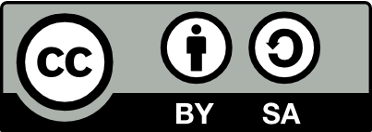</center>

This work was originally created by Sebastian Trimpe and Paul Brunzema. <br> 
It is licensed under Attribution-ShareAlike 4.0 International [(CC-BY-SA 4.0)](https://creativecommons.org/licenses/by-sa/4.0/).